# Projeto 1 - Manipulação de dados - OlistStore

In [13]:
import pandas as pd
import numpy as np
import sqlite3
import matplotlib.pyplot as plt

## Criando tabelas

In [14]:

customers = pd.read_csv('/content/olist_customers_dataset.csv')
geolocation = pd.read_csv('/content/olist_geolocation_dataset.csv')
items = pd.read_csv('/content/olist_order_items_dataset.csv')
payment = pd.read_csv('/content/olist_order_payments_dataset.csv')
reviews = pd.read_csv('/content/olist_order_reviews_dataset.csv')
orders = pd.read_csv('/content/olist_orders_dataset.csv')
products = pd.read_csv('/content/olist_products_dataset.csv')
sellers = pd.read_csv('/content/olist_sellers_dataset.csv')

conn = sqlite3.connect('olist_database.db')  # Change 'your_database.db' if needed
cursor = conn.cursor()

tables_to_delete = [
    'customers',
    'products',
    'geolocation',
    'items',
    'payment',
    'orders',
    'reviews',
    'sellers'
]




# Loop through the tables and drop them if they exist
for table_name in tables_to_delete:
    cursor.execute(f"SELECT name FROM sqlite_master WHERE type='table' AND name='{table_name}'")
    table_exists = cursor.fetchone()

    if table_exists:
        cursor.execute(f"DROP TABLE {table_name}")
        print(f"Table '{table_name}' deleted successfully.")
    else:
        print(f"Table '{table_name}' does not exist.")

        conn.commit()


cursor.execute('''
CREATE TABLE customers (
    customer_id VARCHAR (50) PRIMARY KEY,
    customer_unique_id VARCHAR(50),
    customer_zip_code_prefix VARCHAR(50),
    customer_city VARCHAR(50),
    customer_state VARCHAR(50)
);
''')
conn.commit()

cursor.execute('''
CREATE TABLE products (
    product_id VARCHAR(255) PRIMARY KEY,
    product_category_name VARCHAR(255),
    product_name_lenght INT,
    product_description_lenght INT,
    product_photos_qty INT,
    product_weight_g INT,
    product_length_cm INT,
    product_height_cm INT,
    product_width_cm INT
);
''')
conn.commit()

cursor.execute('''
CREATE TABLE geolocation (
    geolocation_zip_code_prefix VARCHAR(10),
    geolocation_lat DECIMAL(15, 10),
    geolocation_lng DECIMAL(15, 10),
    geolocation_city VARCHAR(100),
    geolocation_state CHAR(2)
);
''')
conn.commit()

cursor.execute('''
CREATE TABLE items (
    order_id VARCHAR(50),
    order_item_id INT,
    product_id VARCHAR(50),
    seller_id VARCHAR(50),
    shipping_limit_date TIMESTAMP,
    price DECIMAL(10, 2),
    freight_value DECIMAL(10, 2),
    PRIMARY KEY (order_id, order_item_id)
);
''')
conn.commit()

cursor.execute('''
CREATE TABLE payment (
    order_id VARCHAR(50),
    payment_sequential INT,
    payment_type VARCHAR(20),
    payment_installments INT,
    payment_value DECIMAL(10, 2),
    PRIMARY KEY (order_id, payment_sequential)
);
''')
conn.commit()

cursor.execute('''
CREATE TABLE orders (
    order_id VARCHAR(50),
    customer_id VARCHAR(50),
    order_status VARCHAR(20),
    order_purchase_timestamp TIMESTAMP,
    order_approved_at TIMESTAMP,
    order_delivered_carrier_date TIMESTAMP,
    order_delivered_customer_date TIMESTAMP,
    order_estimated_delivery_date TIMESTAMP,
    PRIMARY KEY (order_id)
);
''')
conn.commit()

cursor.execute('''
CREATE TABLE reviews (
    review_id VARCHAR(50),
    order_id VARCHAR(50),
    review_score INTEGER,
    review_comment_title TEXT,
    review_comment_message TEXT,
    review_creation_date TIMESTAMP,
    review_answer_timestamp TIMESTAMP,
    PRIMARY KEY (order_id, review_id)
);
''')
conn.commit()

cursor.execute('''
CREATE TABLE sellers (
    seller_id VARCHAR(50),
    seller_zip_code_prefix VARCHAR(10),
    seller_city VARCHAR(50),
    seller_state VARCHAR(2),
    PRIMARY KEY (seller_id)
);
''')
conn.commit()

# Inserindo os dados nas tabelas com pandas e SQLite
customers.to_sql('customers', conn, if_exists='append', index=False)
geolocation.to_sql('geolocation', conn, if_exists='append', index=False)
items.to_sql('items', conn, if_exists='append', index=False)
payment.to_sql('payment', conn, if_exists='append', index=False)
reviews.to_sql('reviews', conn, if_exists='append', index=False)
orders.to_sql('orders', conn, if_exists='append', index=False)
products.to_sql('products', conn, if_exists='append', index=False)
sellers.to_sql('sellers', conn, if_exists='append', index=False)





Table 'customers' does not exist.
Table 'products' does not exist.
Table 'geolocation' does not exist.
Table 'items' does not exist.
Table 'payment' does not exist.
Table 'orders' does not exist.
Table 'reviews' does not exist.
Table 'sellers' does not exist.


3095

## Primeiro Insight : Categorias com maior e menor receita

In [15]:
# Definindo a query 2 corrigida para usar strftime
query2 = '''
SELECT p.product_category_name AS categoria,
       SUM(i.price) AS receita_total,
       COUNT(i.product_id) AS total_vendas
FROM items AS i
JOIN orders AS o ON i.order_id = o.order_id
JOIN products AS p ON i.product_id = p.product_id
WHERE o.order_status = 'delivered'
  AND o.order_purchase_timestamp >= (
    SELECT strftime('%Y-%m-%d %H:%M:%S', DATE(MAX(order_purchase_timestamp), '-12 months'))
    FROM orders
  )
GROUP BY p.product_category_name
ORDER BY receita_total DESC;
'''

# Executando a query 2 corrigida
cursor.execute(query2)

# Recuperando os resultados e carregando-os em um DataFrame
result2 = cursor.fetchall()
df_result2 = pd.DataFrame(result2, columns=["Categoria", "Receita_Total", "Total_Vendas"])

# Exibindo os resultados
df_result2



,Categoria,Receita_Total,Total_Vendas
0,beleza_saude,914888.80,7053
1,relogios_presentes,884771.92,4605
2,cama_mesa_banho,694390.77,7604
3,esporte_lazer,660439.36,5725
4,informatica_acessorios,625468.38,5579
...,...,...,...
68,fashion_roupa_feminina,676.64,18
69,fashion_esporte,489.30,7
70,cds_dvds_musicais,370.00,6
71,casa_conforto_2,241.39,17


## Primeiro insight gráfico : Maior e menor categoria a partir da receita total

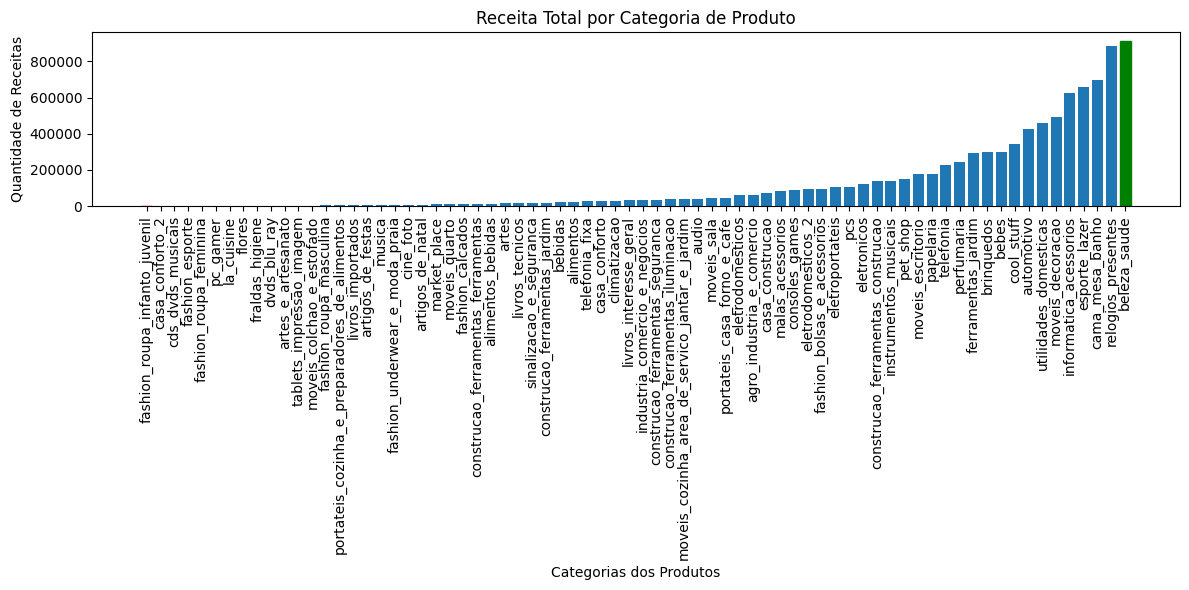

In [16]:
import matplotlib.pyplot as plt

# Ordenar o DataFrame pela receita total
df_result2 = df_result2.sort_values(by='Receita_Total')

# Remover ou substituir valores ausentes na coluna 'Categoria'
# Opção 1: Remover linhas com valores ausentes
df_result2 = df_result2.dropna(subset=['Categoria'])

# Opção 2: Substituir valores ausentes por uma string, por exemplo, "Desconhecido"
# df_result2['Categoria'] = df_result2['Categoria'].fillna("Desconhecido")


# Criar o gráfico de barras
plt.figure(figsize=(12, 6))  # Ajustar o tamanho da figura para melhor visualização
bars = plt.bar(df_result2['Categoria'], df_result2['Receita_Total'])

# Destacar a maior e a menor receita
bars[0].set_color('red')  # Menor receita
bars[-1].set_color('green')  # Maior receita

plt.xlabel("Categorias dos Produtos")
plt.ylabel("Quantidade de Receitas")
plt.title("Receita Total por Categoria de Produto")
plt.xticks(rotation=90)  # Rotacionar os rótulos do eixo x para melhor legibilidade
plt.tight_layout()  # Ajustar o layout para evitar sobreposição de elementos
plt.show()

## Segundo insight: Top 10 maiores sellers (com maior receita)

In [17]:
# Definindo a query 3
query3 = '''
SELECT i.seller_id,
       s.seller_state,
       SUM(i.price) AS receita_total,
       COUNT(i.order_id) AS total_vendas
FROM items AS i
JOIN orders AS o ON i.order_id = o.order_id
JOIN sellers AS s ON i.seller_id = s.seller_id
WHERE o.order_status = 'delivered'
  AND o.order_purchase_timestamp >= (
    SELECT strftime('%Y-%m-%d %H:%M:%S', DATE(MAX(order_purchase_timestamp), '-12 months'))
    FROM orders
  )
GROUP BY i.seller_id, s.seller_state
ORDER BY receita_total DESC
LIMIT 10;
'''

# Executando a query 3
cursor.execute(query3)

# Recuperando os resultados e carregando-os em um DataFrame
result3 = cursor.fetchall()
df_result3 = pd.DataFrame(result3, columns=["Seller_ID", "Seller_State", "Receita_Total", "Total_Vendas"])

# Exibindo os resultados
df_result3


,Seller_ID,Seller_State,Receita_Total,Total_Vendas
0,4869f7a5dfa277a7dca6462dcf3b52b2,SP,181589.70,933
1,fa1c13f2614d7b5c4749cbc52fecda94,SP,136867.85,425
2,955fee9216a65b617aa5c0531780ce60,SP,126164.58,1399
3,1025f0e2d44d7041d6cf58b6550e0bfa,SP,124522.36,1267
4,da8622b14eb17ae2831f4ac5b9dab84a,SP,119795.27,1209
5,7c67e1448b00f6e969d365cea6b010ab,SP,118268.45,879
6,7d13fca15225358621be4086e1eb0964,SP,112436.18,571
7,4a3ca9315b744ce9f8e9374361493884,SP,107867.73,1089
8,53243585a1d6dc2643021fd1853d8905,BA,101288.53,256
9,6560211a19b47992c3666cc44a7e94c0,SP,88748.90,1443


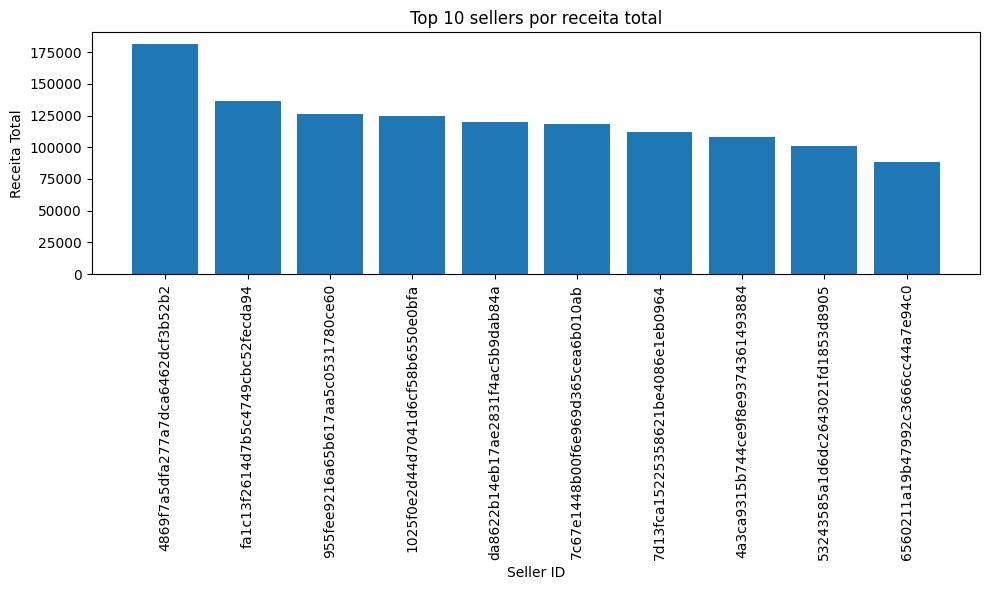

In [18]:


import matplotlib.pyplot as plt

# Create the bar plot
plt.figure(figsize=(10, 6))  # Adjust figure size as needed
plt.bar(df_result3['Seller_ID'], df_result3['Receita_Total'])
plt.xlabel('Seller ID')
plt.ylabel('Receita Total')
plt.title('Top 10 sellers por receita total')
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout to prevent labels from overlapping
plt.show()


## Terceiro insight: Top 10 piores sellers (com menor receita)

In [19]:
# Definindo a query 4
query4 = '''
SELECT i.seller_id,
       s.seller_state,
       SUM(i.price) AS receita_total,
       COUNT(i.order_id) AS total_vendas
FROM items AS i
JOIN orders AS o ON i.order_id = o.order_id
JOIN sellers AS s ON i.seller_id = s.seller_id
WHERE o.order_status = 'delivered'
  AND o.order_purchase_timestamp >= (
    SELECT strftime('%Y-%m-%d %H:%M:%S', DATE(MAX(order_purchase_timestamp), '-12 months'))
    FROM orders
  )
GROUP BY i.seller_id, s.seller_state
ORDER BY receita_total ASC
LIMIT 10;
'''

# Executando a query 4
cursor.execute(query4)

# Recuperando os resultados e carregando-os em um DataFrame
result4 = cursor.fetchall()
df_result4 = pd.DataFrame(result4, columns=["Seller_ID", "Seller_State", "Receita_Total", "Total_Vendas"])

# Exibindo os resultados
df_result4


,Seller_ID,Seller_State,Receita_Total,Total_Vendas
0,1fa2d3def6adfa70e58c276bb64fe5bb,SP,6.90,1
1,08061dc0fc165ed41288cc7acde738ee,SP,7.90,1
2,4965a7002cca77301c82d3f91b82e1a9,SP,8.49,1
3,ad8b531ae67582f096925cff5630d0d1,PR,9.40,1
4,c18309219e789960add0b2255ca4b091,RJ,9.90,1
5,95cca791657aabeff15a07eb152d7841,PR,9.99,1
6,344223b2a90784f64136a8a5da012e7f,SC,10.90,1
7,3ac588cd562971392504a9e17130c40b,SP,11.90,1
8,84deb808079d1be601c209c1e771b1cc,PR,11.90,1
9,cc1f04647be106ba74e62b21f358af25,SP,11.90,1


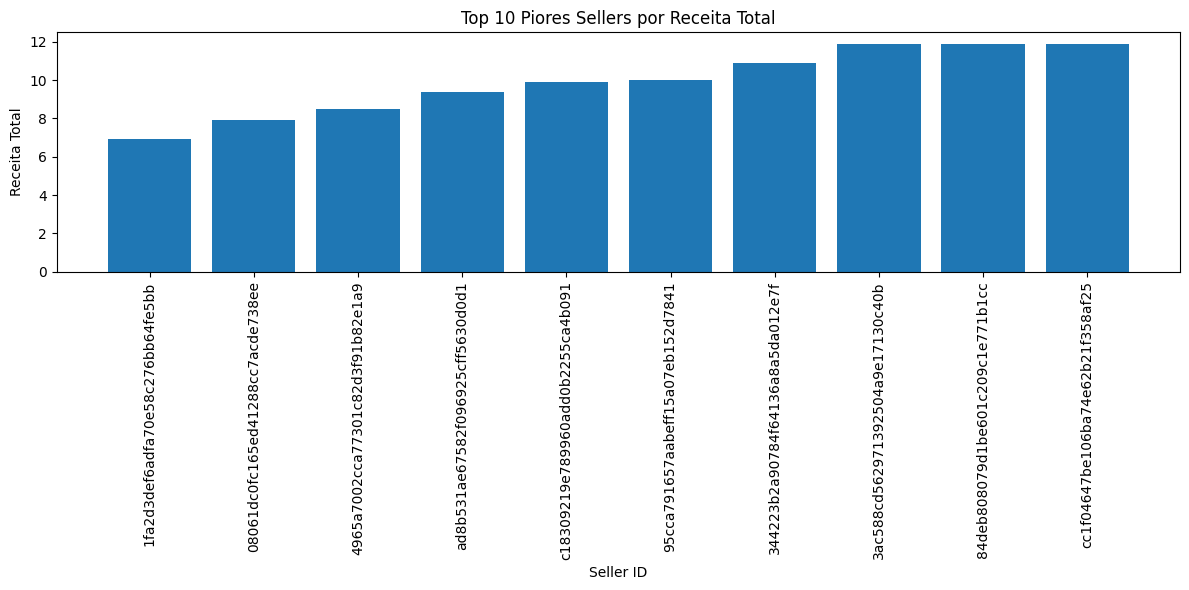

In [20]:

# Criando o gráfico de barras
plt.figure(figsize=(12, 6))  # Ajusta o tamanho da figura
plt.bar(df_result4['Seller_ID'], df_result4['Receita_Total'])
plt.xlabel('Seller ID')
plt.ylabel('Receita Total')
plt.title('Top 10 Piores Sellers por Receita Total')
plt.xticks(rotation=90)  # Rotaciona os rótulos do eixo x para melhor legibilidade
plt.tight_layout()  # Ajusta o layout para evitar sobreposição de elementos
plt.show()

## Quarto insight: Sellers que vendem o mesmo produto e qual a variação de preço entre eles

In [21]:
# Definindo a query ajustada para SQLite
query5 = '''
WITH produtos_vendidos AS (
    SELECT
        i.product_id,
        p.product_category_name,
        s.seller_zip_code_prefix,
        i.price
    FROM items AS i
    JOIN orders AS o ON i.order_id = o.order_id
    JOIN products AS p ON i.product_id = p.product_id
    JOIN sellers AS s ON i.seller_id = s.seller_id
    WHERE o.order_status = 'delivered'
      AND o.order_purchase_timestamp >= (
          SELECT strftime('%Y-%m-%d %H:%M:%S', DATE(MAX(order_purchase_timestamp), '-12 months'))
          FROM orders
      )
),
precos_por_produto AS (
    SELECT
        product_id,
        product_category_name,
        COUNT(DISTINCT seller_zip_code_prefix) AS num_sellers,
        MIN(price) AS preco_minimo,
        MAX(price) AS preco_maximo,
        AVG(price) AS preco_medio
    FROM produtos_vendidos
    GROUP BY product_id, product_category_name
    HAVING COUNT(DISTINCT seller_zip_code_prefix) > 1 -- Apenas produtos vendidos por múltiplos sellers
)
SELECT
    p.product_id,
    p.product_category_name,
    p.num_sellers, -- Número de sellers distintos por produto
    p.preco_minimo,
    p.preco_maximo,
    p.preco_medio,
    (p.preco_maximo - p.preco_minimo) AS variacao_preco,
    GROUP_CONCAT(DISTINCT v.seller_zip_code_prefix) AS seller_zip_codes -- Correção aqui
FROM precos_por_produto AS p
JOIN produtos_vendidos AS v ON p.product_id = v.product_id
GROUP BY
    p.product_id,
    p.product_category_name,
    p.num_sellers,
    p.preco_minimo,
    p.preco_maximo,
    p.preco_medio
ORDER BY variacao_preco DESC;
'''

# Executando a query no SQLite
cursor.execute(query5)

# Recuperando os resultados e carregando-os em um DataFrame
result_produtos = cursor.fetchall()
df_produtos = pd.DataFrame(result_produtos, columns=[
    "Product_ID",
    "Product_Category",
    "Num_Sellers",
    "Preco_Minimo",
    "Preco_Maximo",
    "Preco_Medio",
    "Variacao_Preco",
    "Seller_Zip_Codes"
])

# Exibindo o DataFrame
df_produtos


,Product_ID,Product_Category,Num_Sellers,Preco_Minimo,Preco_Maximo,Preco_Medio,Variacao_Preco,Seller_Zip_Codes
0,53d8ee87caa1a2320c66074ff9c99e61,relogios_presentes,2,516.90,799.00,582.947500,282.10,"9920,3345"
1,748efd895fa2f88b0c89579fb092e792,informatica_acessorios,2,529.90,759.90,643.240000,230.00,"87114,87083"
2,c1ad8ac66c91ad301cefc322ba2adf31,relogios_presentes,2,488.00,699.99,552.489000,211.99,"9920,6429"
3,933f4f76eae38d2a97ecfb7c6355f0bc,beleza_saude,2,1299.65,1499.90,1381.292857,200.25,"88215,25957"
4,f819f0c84a64f02d3a5606ca95edd272,relogios_presentes,4,499.90,699.00,631.376923,199.10,"14050,14840,7180,14850"
...,...,...,...,...,...,...,...,...
773,bdb0b11a36aed4d0d862a7037c838560,telefonia,2,1099.00,1099.00,1099.000000,0.00,"24120,5734"
774,be4e205f4a7283ce05c3b9365d283adc,esporte_lazer,2,29.99,29.99,29.990000,0.00,"7091,4265"
775,e090b9bd2ef7d60d3b0ee3399c79ee3d,informatica_acessorios,2,235.92,235.92,235.920000,0.00,"12233,87114"
776,e2998bdeb405a823c497b3ea4e3f263e,beleza_saude,2,120.00,120.00,120.000000,0.00,"12020,12327"


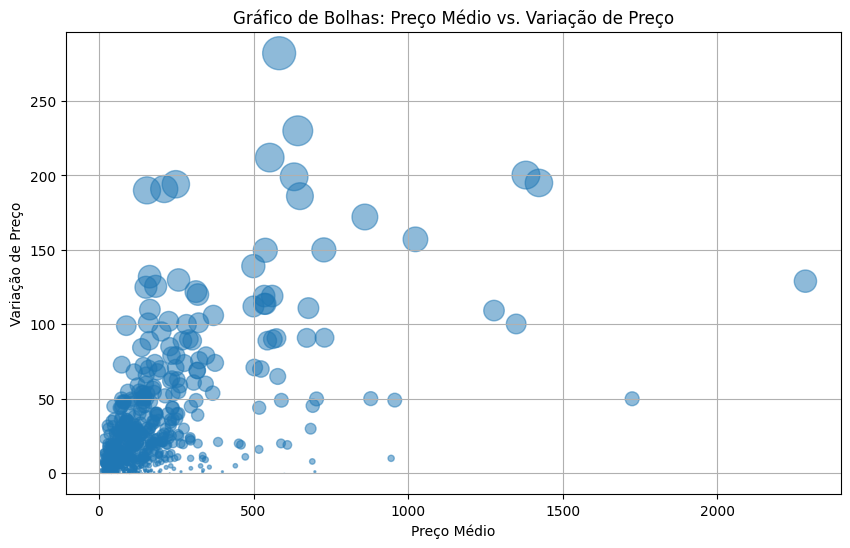

In [22]:
# prompt: Usando o DataFrame df_produtos: faça um gráfico de bolhas usando a matplotlib , com uma coluna de preço médio dos  produtos e outra coluna com a variação de preço

import matplotlib.pyplot as plt

# Criar o gráfico de bolhas
plt.figure(figsize=(10, 6))  # Ajustar o tamanho da figura
plt.scatter(df_produtos['Preco_Medio'], df_produtos['Variacao_Preco'], s=df_produtos['Variacao_Preco'] * 2, alpha=0.5)

# Adicionar rótulos e título
plt.xlabel('Preço Médio')
plt.ylabel('Variação de Preço')
plt.title('Gráfico de Bolhas: Preço Médio vs. Variação de Preço')

# Adicionar uma grid para melhor visualização
plt.grid(True)

# Exibir o gráfico
plt.show()

## Quinto insight: Inflação no preço dos produtos

### Inflação simples:

In [23]:
from IPython.display import display

query6 = """
WITH primeiro_preco AS (
    SELECT i.product_id,
           p.product_category_name,
           i.price AS preco_inicial,
           o.order_purchase_timestamp,
           ROW_NUMBER() OVER (PARTITION BY i.product_id ORDER BY o.order_purchase_timestamp ASC) AS rn
    FROM items AS i
    JOIN orders AS o ON i.order_id = o.order_id
    JOIN products AS p ON i.product_id = p.product_id
    WHERE o.order_status = 'delivered'
      AND o.order_purchase_timestamp >= (SELECT strftime('%Y-%m-%d %H:%M:%S', DATE(MAX(order_purchase_timestamp), '-12 months')) FROM orders)
),
ultimo_preco AS (
    SELECT i.product_id,
           i.price AS preco_final,
           o.order_purchase_timestamp,
           ROW_NUMBER() OVER (PARTITION BY i.product_id ORDER BY o.order_purchase_timestamp DESC) AS rn
    FROM items AS i
    JOIN orders AS o ON i.order_id = o.order_id
    WHERE o.order_status = 'delivered'
      AND o.order_purchase_timestamp >= (SELECT strftime('%Y-%m-%d %H:%M:%S', DATE(MAX(order_purchase_timestamp), '-12 months')) FROM orders)
)
SELECT p.product_id,
       p.product_category_name,
       f.preco_inicial,
       l.preco_final,
       (l.preco_final - f.preco_inicial) AS inflacao_reais,
       -- Fórmula corrigida para inflação percentual:
       CASE
           WHEN l.preco_final != 0 THEN  -- Evitar divisão por zero
               ROUND(((l.preco_final - f.preco_inicial) * 100.0) / l.preco_final, 2)
           ELSE NULL
       END AS inflacao_percentual
FROM primeiro_preco AS f
JOIN ultimo_preco AS l ON f.product_id = l.product_id
JOIN products AS p ON f.product_id = p.product_id
WHERE f.rn = 1
  AND l.rn = 1
ORDER BY inflacao_reais DESC;
"""

# Execute a query
cursor.execute(query6)

# Recupere os resultados
resultados = cursor.fetchall()

# Crie um DataFrame com os resultados
colunas = ['product_id', 'product_category_name', 'preco_inicial', 'preco_final', 'inflacao_reais', 'inflacao_percentual']
df_inflacao = pd.DataFrame(resultados, columns=colunas)

# Exiba o DataFrame
display(df_inflacao)



,product_id,product_category_name,preco_inicial,preco_final,inflacao_reais,inflacao_percentual
0,4cce3fa9fee9eb2361e0b9bd32516958,construcao_ferramentas_construcao,799.00,1260.00,461.00,36.59
1,c1afa44a5a60e2e7cf7280e57eba0597,ferramentas_jardim,1050.00,1450.00,400.00,27.59
2,dd113cb02b2af9c8e5787e8f1f0722f6,esporte_lazer,3690.00,4059.00,369.00,9.09
3,44fc450365728c413fefc547592626be,eletroportateis,599.00,950.00,351.00,36.95
4,25292482a61cb3298df8dbe15ea69daf,beleza_saude,1149.65,1499.65,350.00,23.34
...,...,...,...,...,...,...
24341,c1ad8ac66c91ad301cefc322ba2adf31,relogios_presentes,699.99,490.00,-209.99,-42.86
24342,bebd360fe73dc670fd6439e9b943ceb7,relogios_presentes,959.00,746.00,-213.00,-28.55
24343,748efd895fa2f88b0c89579fb092e792,informatica_acessorios,759.90,529.90,-230.00,-43.40
24344,57c9362442482cd2451f2eabf468e532,relogios_presentes,1099.99,869.00,-230.99,-26.58


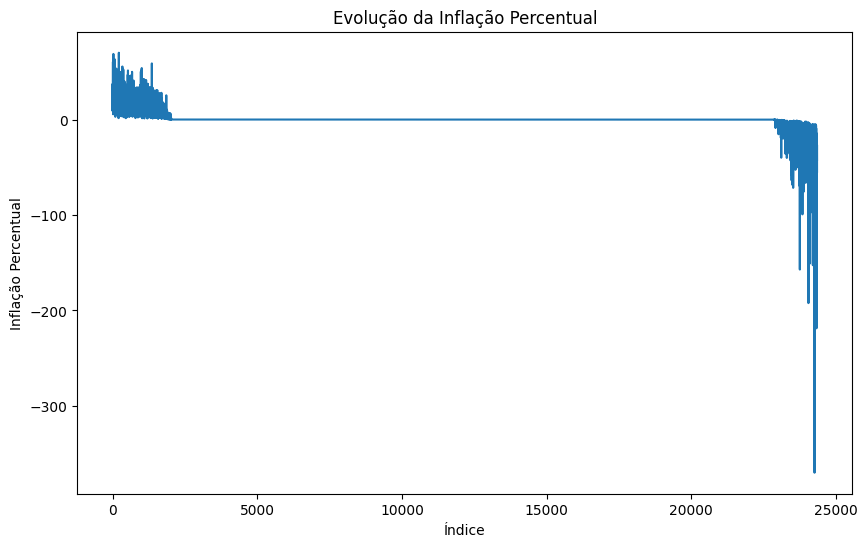

In [24]:
# prompt: Usando o DataFrame df_inflacao: gere um gráfico com a matplotlib mostrando a evolução da inflação percentual

import matplotlib.pyplot as plt

# Criar o gráfico de linha
plt.figure(figsize=(10, 6))  # Ajustar o tamanho da figura
plt.plot(df_inflacao.index, df_inflacao['inflacao_percentual'])

# Adicionar rótulos e título
plt.xlabel('Índice')
plt.ylabel('Inflação Percentual')
plt.title('Evolução da Inflação Percentual')

# Mostrar o gráfico
plt.show()

### Inflação com o indice IPCA

In [25]:
query7 = """
WITH dados_preco AS (
    SELECT
        i.price AS preco,
        p.product_id,
        p.product_category_name AS categoria_produto,
        o.order_purchase_timestamp AS data_compra
    FROM
        items AS i
    JOIN
        orders AS o ON i.order_id = o.order_id
    JOIN
        products AS p ON i.product_id = p.product_id
    WHERE
        o.order_purchase_timestamp >= (SELECT strftime('%Y-%m-%d %H:%M:%S', DATE(MAX(order_purchase_timestamp), '-12 months')) FROM orders)
),
precos_primeiro_ultimo AS (
    SELECT
        product_id,
        categoria_produto,
        MIN(preco) AS preco_inicial,
        MAX(preco) AS preco_final
    FROM dados_preco
    GROUP BY product_id, categoria_produto
)
SELECT
    fl.product_id,
    fl.categoria_produto,
    fl.preco_inicial,
    fl.preco_final,
    -- Aplicando inflação de 3,75%
    fl.preco_inicial * (1 + 0.0375) AS preco_inicial_ajustado,
    -- Calculando a variação ajustada pela inflação
    fl.preco_final - (fl.preco_inicial * (1 + 0.0375)) AS variacao_ajustada,
    -- Calculando a variação de preços em porcentagem (em reais)
    ((fl.preco_final - (fl.preco_inicial * (1 + 0.0375))) / (fl.preco_inicial * (1 + 0.0375))) * 100 AS inflacao_percentual
FROM
    precos_primeiro_ultimo AS fl
ORDER BY
    variacao_ajustada DESC;
"""

cursor.execute(query7)

# Recupere os resultados
resultados = cursor.fetchall()

# Crie um DataFrame com os resultados
colunas = ['product_id', 'categoria_produto', 'preco_inicial', 'preco_final', 'preco_inicial_ajustado', 'variacao_ajustada', 'inflacao_percentual']
df_inflacao_ajustada = pd.DataFrame(resultados, columns=colunas)

# Exiba o DataFrame
display(df_inflacao_ajustada)

,product_id,categoria_produto,preco_inicial,preco_final,preco_inicial_ajustado,variacao_ajustada,inflacao_percentual
0,4cce3fa9fee9eb2361e0b9bd32516958,construcao_ferramentas_construcao,799.00,1260.00,828.962500,431.037500,51.997225
1,c1afa44a5a60e2e7cf7280e57eba0597,ferramentas_jardim,1050.00,1450.00,1089.375000,360.625000,33.103844
2,44fc450365728c413fefc547592626be,eletroportateis,599.00,950.00,621.462500,328.537500,52.865217
3,25292482a61cb3298df8dbe15ea69daf,beleza_saude,1149.65,1499.65,1192.761875,306.888125,25.729203
4,cce3ce6484896041ae3dafdd4308a39c,consoles_games,1004.99,1314.99,1042.677125,272.312875,26.116702
...,...,...,...,...,...,...,...
24776,0563d4cc419141eab2e5b438046e844e,ferramentas_jardim,3930.00,3930.00,4077.375000,-147.375000,-3.614458
24777,6cdf8fc1d741c76586d8b6b15e9eef30,consoles_games,4099.99,4099.99,4253.739625,-153.749625,-3.614458
24778,a1beef8f3992dbd4cd8726796aa69c53,instrumentos_musicais,4399.87,4399.87,4564.865125,-164.995125,-3.614458
24779,259037a6a41845e455183f89c5035f18,pcs,4590.00,4590.00,4762.125000,-172.125000,-3.614458


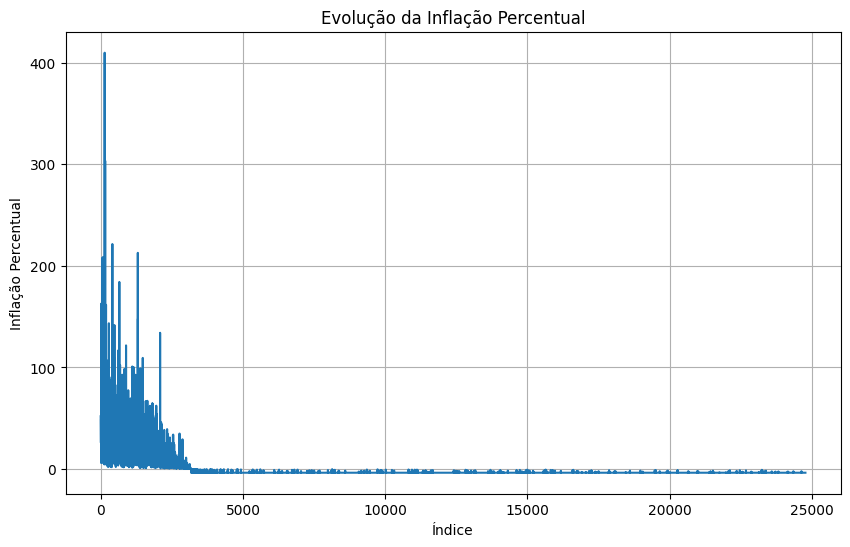

In [26]:


import matplotlib.pyplot as plt

# Crie o gráfico de linha
plt.figure(figsize=(10, 6))  # Ajuste o tamanho da figura conforme necessário
plt.plot(df_inflacao_ajustada['inflacao_percentual'])

# Adicione rótulos e título
plt.xlabel('Índice') # Substitua 'Índice' por um rótulo mais descritivo se disponível no seu DataFrame
plt.ylabel('Inflação Percentual')
plt.title('Evolução da Inflação Percentual')

# Adicione uma grade para melhor legibilidade
plt.grid(True)

# Exiba o gráfico
plt.show()

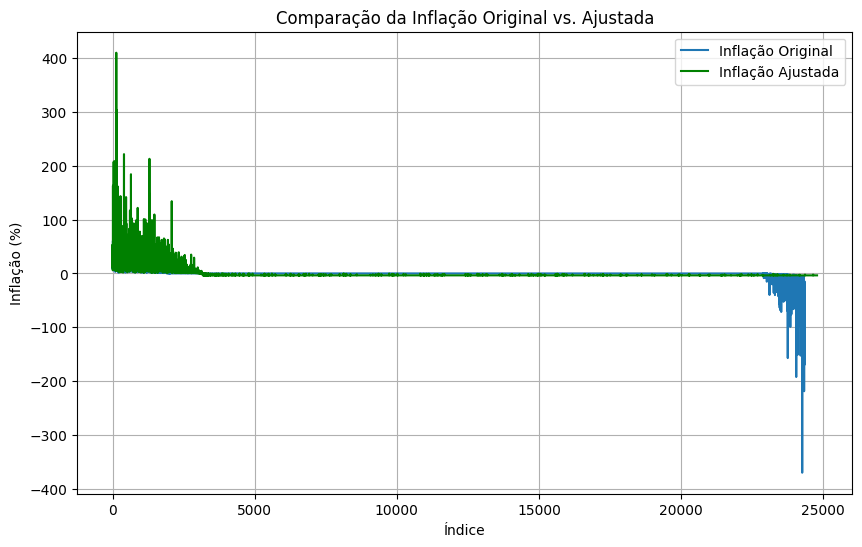

In [27]:

# Criar o gráfico de comparação
plt.figure(figsize=(10, 6))

# Plotar a inflação original
plt.plot(df_inflacao.index, df_inflacao['inflacao_percentual'], label='Inflação Original')

# Plotar a inflação ajustada em verde
plt.plot(df_inflacao_ajustada.index, df_inflacao_ajustada['inflacao_percentual'], color='green', label='Inflação Ajustada')

# Adicionar rótulos e título
plt.xlabel('Índice')
plt.ylabel('Inflação (%)')
plt.title('Comparação da Inflação Original vs. Ajustada')
plt.legend()
plt.grid(True)

# Exibir o gráfico
plt.show()

## Sexto insight: Top 10 melhores sellers com melhores reviews

In [28]:
query8 = """
WITH seller_sales AS (
    SELECT
        s.seller_id,
        COUNT(i.order_id) AS total_vendas
    FROM items AS i
    JOIN orders AS o ON i.order_id = o.order_id
    JOIN sellers AS s ON i.seller_id = s.seller_id
    WHERE o.order_status = 'delivered'
        AND o.order_purchase_timestamp >= (SELECT strftime('%Y-%m-%d %H:%M:%S', DATE(MAX(order_purchase_timestamp), '-12 months')) FROM orders)
    GROUP BY s.seller_id
),
average_sales AS (
    SELECT AVG(total_vendas) AS media_vendas
    FROM seller_sales
),
seller_reviews AS (
    SELECT
        s.seller_id,
        AVG(
            CASE
                WHEN r.review_score = 1 THEN 0.25
                WHEN r.review_score = 2 THEN 0.5
                WHEN r.review_score = 3 THEN 1.0
                WHEN r.review_score = 4 THEN 1.25
                WHEN r.review_score = 5 THEN 1.5
            END
        ) AS qualidade_reviews
    FROM reviews AS r
    JOIN orders AS o ON r.order_id = o.order_id
    JOIN items AS i ON o.order_id = i.order_id
    JOIN sellers AS s ON i.seller_id = s.seller_id
    WHERE o.order_status = 'delivered'
        AND o.order_purchase_timestamp >= (SELECT strftime('%Y-%m-%d %H:%M:%S', DATE(MAX(order_purchase_timestamp), '-12 months')) FROM orders)
    GROUP BY s.seller_id
),
filtered_sellers AS (
    SELECT
        ss.seller_id,
        ss.total_vendas,
        sr.qualidade_reviews
    FROM seller_sales AS ss
    JOIN seller_reviews AS sr ON ss.seller_id = sr.seller_id
    JOIN average_sales AS av ON ss.total_vendas >= av.media_vendas
)
SELECT
    fs.seller_id,
    fs.total_vendas,
    fs.qualidade_reviews
FROM filtered_sellers AS fs
ORDER BY fs.qualidade_reviews DESC
LIMIT 10;
"""

# Executando a query
cursor.execute(query8)

# Recuperando os resultados
resultados = cursor.fetchall()

# Convertendo os resultados para um DataFrame
colunas = ['seller_id', 'total_vendas', 'qualidade_reviews']
df_sellers = pd.DataFrame(resultados, columns=colunas)

# Exibindo o DataFrame
print(df_sellers)


                          seller_id  total_vendas  qualidade_reviews
0  b410bdd36d5db7a65dcd42b7ead933b8            42           1.452381
1  d9bd94811c3338dceb4181f3dbc0c73e            61           1.446721
2  d13e50eaa47b4cbe9eb81465865d8cfc            68           1.444853
3  376a891762bbdecbc02b4b6adec3fdda            40           1.431250
4  5f1dc28029d2c244352a68107ec2b542            44           1.430233
5  d566c37fa119d5e66c4e9052e83ee4ea            73           1.422535
6  6061155addc1e54b4cfb51c1c2a32ad8            33           1.421429
7  18e694e0e48ed6f7aa3f24aade5fd697            34           1.419118
8  080199a181c46c657dc5aa235411be3b            76           1.406667
9  0432ead42b6c8a0bdf68154add917fdf            31           1.395161


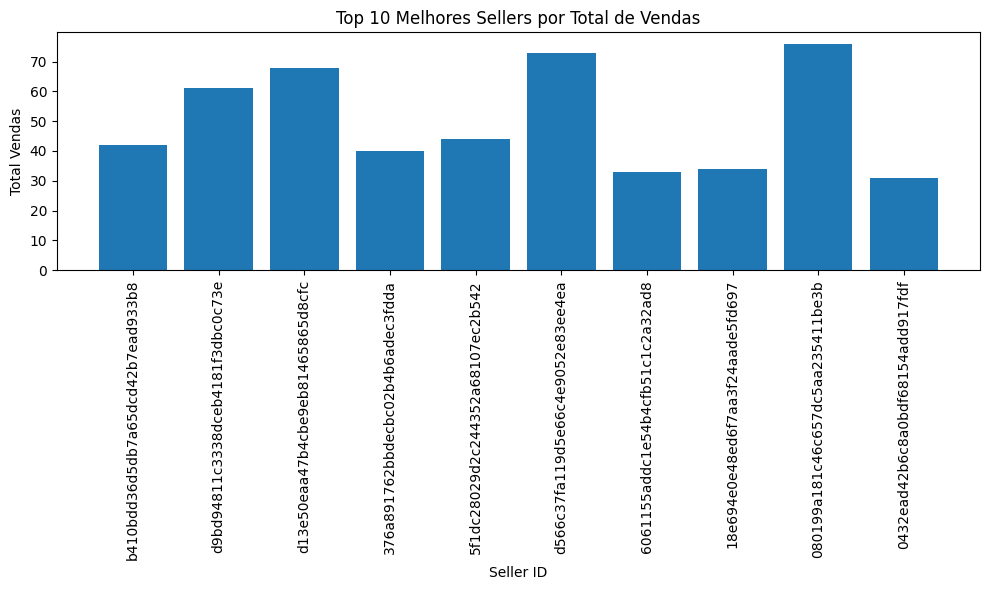

In [29]:

# Create the bar plot
plt.figure(figsize=(10, 6))  # Adjust figure size as needed
plt.bar(df_sellers['seller_id'], df_sellers['total_vendas'])
plt.xlabel('Seller ID')
plt.ylabel('Total Vendas')
plt.title('Top 10 Melhores Sellers por Total de Vendas')
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout to prevent labels from overlapping
plt.show()

## Sétimo Insight : Top 10 piores sellers com as piores reviews

In [30]:
query9 = """
WITH seller_sales AS (
    SELECT
        s.seller_id,
        COUNT(i.order_id) AS total_vendas
    FROM items AS i
    JOIN orders AS o ON i.order_id = o.order_id
    JOIN sellers AS s ON i.seller_id = s.seller_id
    WHERE o.order_status = 'delivered'
        AND o.order_purchase_timestamp >= (SELECT strftime('%Y-%m-%d %H:%M:%S', DATE(MAX(order_purchase_timestamp), '-12 months')) FROM orders)
    GROUP BY s.seller_id
),
average_sales AS (
    SELECT AVG(total_vendas) AS media_vendas
    FROM seller_sales
),
seller_reviews AS (
    SELECT
        s.seller_id,
        AVG(
            CASE
                WHEN r.review_score = 1 THEN 0.25
                WHEN r.review_score = 2 THEN 0.5
                WHEN r.review_score = 3 THEN 1.0
                WHEN r.review_score = 4 THEN 1.25
                WHEN r.review_score = 5 THEN 1.5
            END
        ) AS qualidade_reviews
    FROM reviews AS r
    JOIN orders AS o ON r.order_id = o.order_id
    JOIN items AS i ON o.order_id = i.order_id
    JOIN sellers AS s ON i.seller_id = s.seller_id
    WHERE o.order_status = 'delivered'
        AND o.order_purchase_timestamp >= (SELECT strftime('%Y-%m-%d %H:%M:%S', DATE(MAX(order_purchase_timestamp), '-12 months')) FROM orders)
    GROUP BY s.seller_id
),
filtered_sellers AS (
    SELECT
        ss.seller_id,
        ss.total_vendas,
        sr.qualidade_reviews
    FROM seller_sales AS ss
    JOIN seller_reviews AS sr ON ss.seller_id = sr.seller_id
    JOIN average_sales AS av ON ss.total_vendas >= av.media_vendas
)
SELECT
    fs.seller_id,
    fs.total_vendas,
    fs.qualidade_reviews
FROM filtered_sellers AS fs
ORDER BY fs.qualidade_reviews ASC -- Ordenar pelas piores reviews
LIMIT 10;
"""

# Executando a query
cursor.execute(query9)

# Recuperando os resultados
resultados = cursor.fetchall()

# Convertendo os resultados para um DataFrame
colunas = ['seller_id', 'total_vendas', 'qualidade_reviews']
df_sellers_piores = pd.DataFrame(resultados, columns=colunas)

# Exibindo o DataFrame
print(df_sellers_piores)


                          seller_id  total_vendas  qualidade_reviews
0  1ca7077d890b907f89be8c954a02686a           119           0.625000
1  a49928bcdf77c55c6d6e05e09a9b4ca5            53           0.740566
2  2eb70248d66e0e3ef83659f71b244378           197           0.832051
3  8444e55c1f13cd5c179851e5ca5ebd00            56           0.839286
4  bbad7e518d7af88a0897397ffdca1979            62           0.866935
5  972d0f9cf61b499a4812cf0bfa3ad3c4            86           0.880952
6  602044f2c16190c2c6e45eb35c2e21cb            55           0.890351
7  710e3548e02bc1d2831dfc4f1b5b14d4            78           0.894231
8  8e6d7754bc7e0f22c96d255ebda59eba           129           0.897727
9  54965bbe3e4f07ae045b90b0b8541f52            81           0.911184


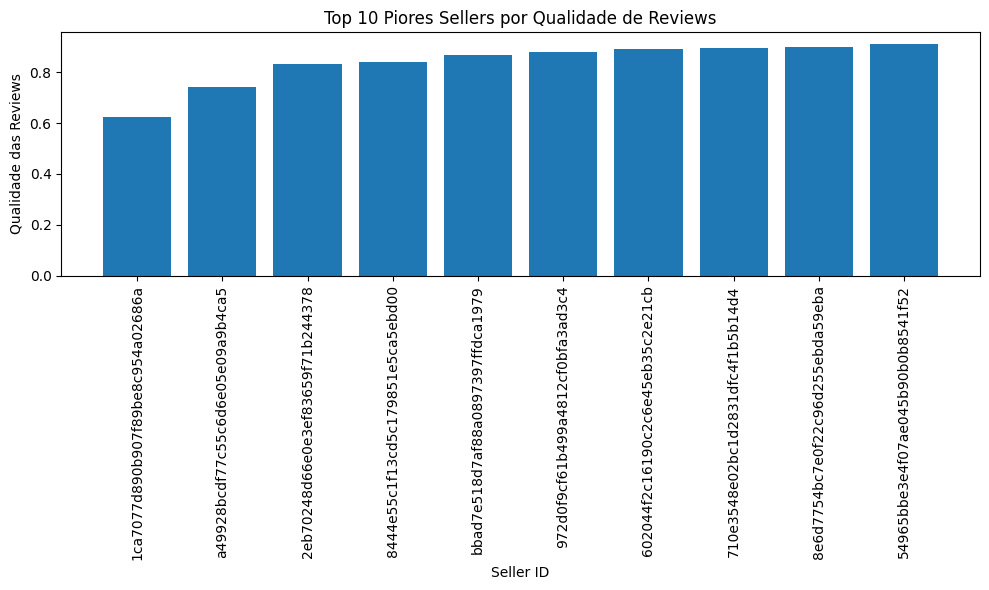

In [31]:
# prompt: gere um gráfico da tabela dos top 10 piores sellers com as piores qualidade de reviews

import matplotlib.pyplot as plt

# Create the bar plot
plt.figure(figsize=(10, 6))  # Adjust figure size as needed
plt.bar(df_sellers_piores['seller_id'], df_sellers_piores['qualidade_reviews'])
plt.xlabel('Seller ID')
plt.ylabel('Qualidade das Reviews')
plt.title('Top 10 Piores Sellers por Qualidade de Reviews')
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout to prevent labels from overlapping
plt.show()

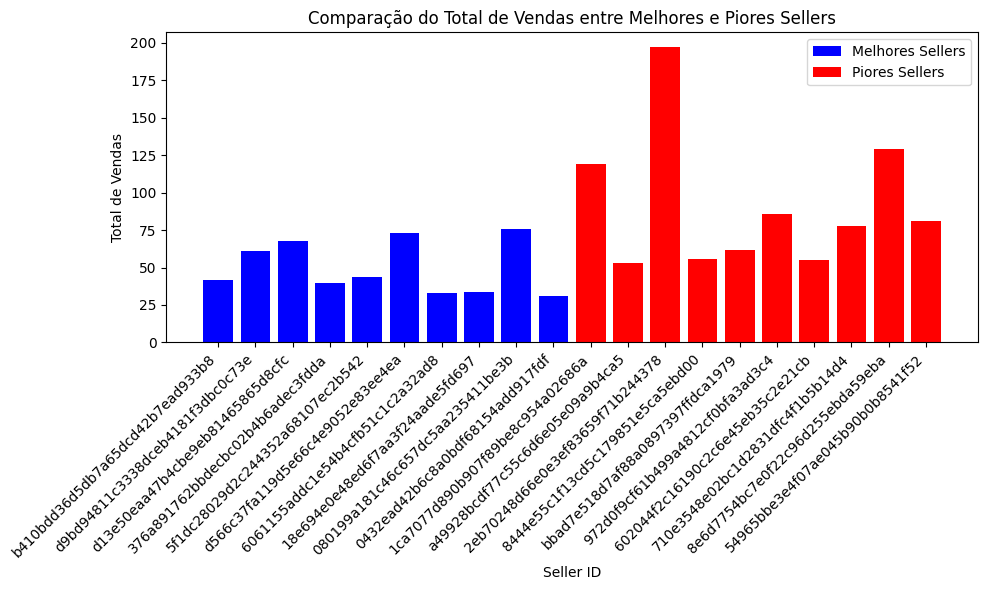

In [32]:

# Criar o gráfico de comparação
plt.figure(figsize=(10, 6))

# Plotar os dados de df_sellers em azul
plt.bar(df_sellers['seller_id'], df_sellers['total_vendas'], color='blue', label='Melhores Sellers')

# Plotar os dados de df_sellers_piores em vermelho
plt.bar(df_sellers_piores['seller_id'], df_sellers_piores['total_vendas'], color='red', label='Piores Sellers')

# Adicionar rótulos e título
plt.xlabel('Seller ID')
plt.ylabel('Total de Vendas')
plt.title('Comparação do Total de Vendas entre Melhores e Piores Sellers')
plt.xticks(rotation=45, ha='right')  # Rotacionar rótulos do eixo x para melhor legibilidade
plt.legend()
plt.tight_layout()  # Ajustar o layout para evitar sobreposição

# Exibir o gráfico
plt.show()

## Oitavo insight: relação entre quantidade de vendas e a qualidade das reviews, identificar se houve um aumento ou uma queda nas vendas com base no que ja foi vendido no passado

#### relacionando vendas e reviews totais

In [39]:
query10 = """
SELECT
    s.seller_id,
    COUNT(DISTINCT i.order_id) AS total_vendas,
    COUNT(DISTINCT r.review_id) AS total_reviews
FROM sellers AS s
LEFT JOIN items AS i ON s.seller_id = i.seller_id
LEFT JOIN reviews AS r ON i.order_id = r.order_id
GROUP BY s.seller_id
ORDER BY total_vendas DESC;
"""

# Executando a query e transformando em DataFrame
result = pd.read_sql_query(query10, conn)

# Exibindo os resultados
print(result)


                             seller_id  total_vendas  total_reviews
0     6560211a19b47992c3666cc44a7e94c0          1854           1841
1     4a3ca9315b744ce9f8e9374361493884          1806           1800
2     cc419e0650a3c5ba77189a1882b7556a          1706           1707
3     1f50f920176fa81dab994f9023523100          1404           1404
4     da8622b14eb17ae2831f4ac5b9dab84a          1314           1309
...                                ...           ...            ...
3090  fe9d9cf8631285d5982c6e2cf27fb114             1              1
3091  feb793c88d836c3a75efa4b5a3465d70             1              1
3092  fec6912baad85d41729669edd6b4d3b8             1              1
3093  fedaedd3ca31d56ab33e92035e4b361c             1              1
3094  ffcfefa19b08742c5d315f2791395ee5             1              1

[3095 rows x 3 columns]


#### evolução ao longo do tempo (em meses)

In [43]:
query11 = """
SELECT
    s.seller_id,
    STRFTIME('%Y-%m', o.order_purchase_timestamp) AS mes,
    COUNT(i.order_id) AS total_vendas,
    COUNT(r.review_id) AS total_reviews,
    o.order_id
FROM sellers AS s
JOIN items AS i ON s.seller_id = i.seller_id
JOIN orders AS o ON i.order_id = o.order_id
LEFT JOIN reviews AS r ON o.order_id = r.order_id
GROUP BY s.seller_id, mes, o.order_id
ORDER BY s.seller_id, mes;
"""

result11 = pd.read_sql_query(query11, conn)

df_vendas_reviews = pd.merge(result11, reviews[['order_id', 'review_score']], on='order_id', how='left')
print(df_vendas_reviews)


                               seller_id      mes  total_vendas  \
0       0015a82c2db000af6aaaf3ae2ecb0532  2017-09             1   
1       0015a82c2db000af6aaaf3ae2ecb0532  2017-10             1   
2       0015a82c2db000af6aaaf3ae2ecb0532  2017-10             1   
3       001cca7ae9ae17fb1caed9dfb1094831  2017-02             1   
4       001cca7ae9ae17fb1caed9dfb1094831  2017-02             2   
...                                  ...      ...           ...   
100567  ffff564a4f9085cd26170f4732393726  2017-03             1   
100568  ffff564a4f9085cd26170f4732393726  2017-03             1   
100569  ffff564a4f9085cd26170f4732393726  2017-03             1   
100570  ffff564a4f9085cd26170f4732393726  2017-03             1   
100571  ffff564a4f9085cd26170f4732393726  2017-04             1   

        total_reviews                          order_id  review_score  
0                   1  d455a8cb295653b55abda06d434ab492           5.0  
1                   1  7f39ba4c9052be115350065d0758

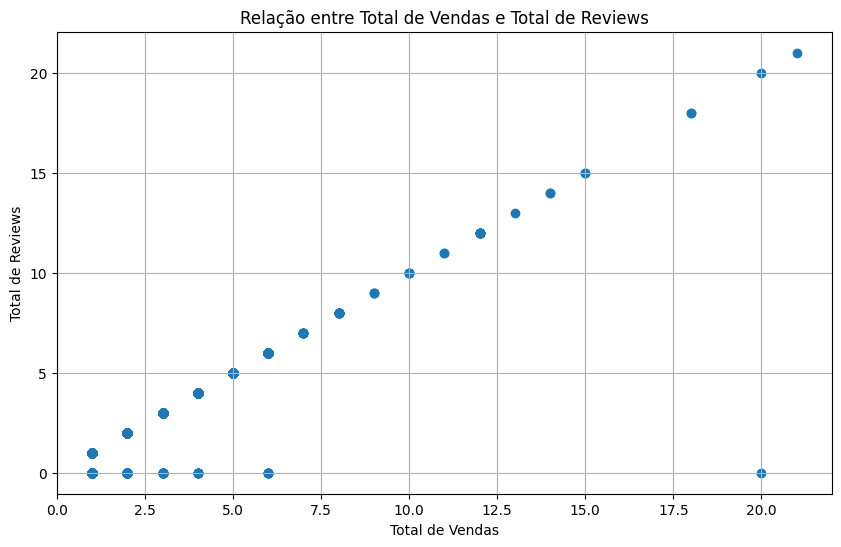

In [44]:



# Criar o gráfico de dispersão
plt.figure(figsize=(10, 6))
plt.scatter(df_vendas_reviews['total_vendas'], df_vendas_reviews['total_reviews'])
plt.xlabel('Total de Vendas')
plt.ylabel('Total de Reviews')
plt.title('Relação entre Total de Vendas e Total de Reviews')
plt.grid(True)
plt.show()

In [46]:
# Exiba a correlação de Pearson entre 'total_vendas' e 'total_reviews' em uma linha
correlacao_pearson_valor = df_vendas_reviews[['total_vendas', 'total_reviews']].corr(method='pearson').iloc[0, 1]
print(f"Correlação de Pearson entre Total de Vendas e Total de Reviews: {correlacao_pearson_valor}")


Correlação de Pearson entre Total de Vendas e Total de Reviews: 0.9690273602634515


# Insight livre

In [48]:
#cidade com mais vendas
query_cidade_mais_vendas = """
SELECT s.seller_city AS cidade,
       COUNT(i.order_id) AS total_vendas
FROM sellers s
JOIN items i ON s.seller_id = i.seller_id
JOIN orders o ON i.order_id = o.order_id
WHERE o.order_status = 'delivered'
GROUP BY s.seller_city
ORDER BY total_vendas DESC
LIMIT 10;
"""

cidade_mais_vendas = pd.read_sql_query(query_cidade_mais_vendas, conn)
print("Cidade com mais vendas:", cidade_mais_vendas)


Cidade com mais vendas:                   cidade  total_vendas
0              sao paulo         27357
1               ibitinga          7621
2               curitiba          2955
3            santo andre          2886
4  sao jose do rio preto          2544
5         belo horizonte          2522
6         rio de janeiro          2356
7              guarulhos          2309
8         ribeirao preto          2208
9                maringa          2194


In [50]:
query_cidade_mais_compras = """
SELECT c.customer_city AS cidade,
       COUNT(o.order_id) AS total_compras
FROM customers c
JOIN orders o ON c.customer_id = o.customer_id
WHERE o.order_status = 'delivered'
GROUP BY c.customer_city
ORDER BY total_compras DESC
LIMIT 10;
"""
cidade_mais_compras = pd.read_sql_query(query_cidade_mais_compras, conn)
print("Cidade com mais compras:", cidade_mais_compras)


Cidade com mais compras:                   cidade  total_compras
0              sao paulo          15045
1         rio de janeiro           6601
2         belo horizonte           2697
3               brasilia           2071
4               curitiba           1489
5               campinas           1406
6           porto alegre           1342
7               salvador           1188
8              guarulhos           1144
9  sao bernardo do campo            911


In [52]:
query_cidade_mais_entregas = """
SELECT c.customer_city AS cidade,
       COUNT(o.order_id) AS total_entregas
FROM customers c
JOIN orders o ON c.customer_id = o.customer_id
WHERE o.order_status = 'delivered'
GROUP BY c.customer_city
ORDER BY total_entregas DESC
LIMIT 10;
"""
cidade_mais_entregas = pd.read_sql_query(query_cidade_mais_entregas, conn)
print("Cidade com mais entregas:", cidade_mais_entregas)


Cidade com mais entregas:                   cidade  total_entregas
0              sao paulo           15045
1         rio de janeiro            6601
2         belo horizonte            2697
3               brasilia            2071
4               curitiba            1489
5               campinas            1406
6           porto alegre            1342
7               salvador            1188
8              guarulhos            1144
9  sao bernardo do campo             911


In [59]:
# Consulta para calcular a média de frete nas top 10 cidades com mais entregas
query_media_frete = """
SELECT c.customer_city AS cidade,
       AVG(p.payment_value) AS media_frete
FROM customers c
JOIN orders o ON c.customer_id = o.customer_id
JOIN payment p ON o.order_id = p.order_id
WHERE o.order_status = 'delivered'
  AND c.customer_city IN ({})
GROUP BY c.customer_city
ORDER BY media_frete DESC;
""".format(",".join(["?"] * len(cidade_mais_entregas)))

# Extrair as cidades das entregas mais frequentes
top_cidades = cidade_mais_entregas['cidade'].tolist()

# Executar a consulta com as cidades como parâmetros
media_frete = pd.read_sql_query(query_media_frete, conn, params=top_cidades)

# Exibir a média do frete para as cidades com mais entregas
print("Média do frete para as top 10 cidades com mais entregas:")
print(media_frete)




Média do frete para as top 10 cidades com mais entregas:
                  cidade  media_frete
0               brasilia   161.999939
1               salvador   161.078209
2         rio de janeiro   160.744878
3           porto alegre   155.696978
4               curitiba   154.522189
5         belo horizonte   145.433693
6               campinas   141.522661
7              sao paulo   134.303511
8              guarulhos   131.130540
9  sao bernardo do campo   122.673540


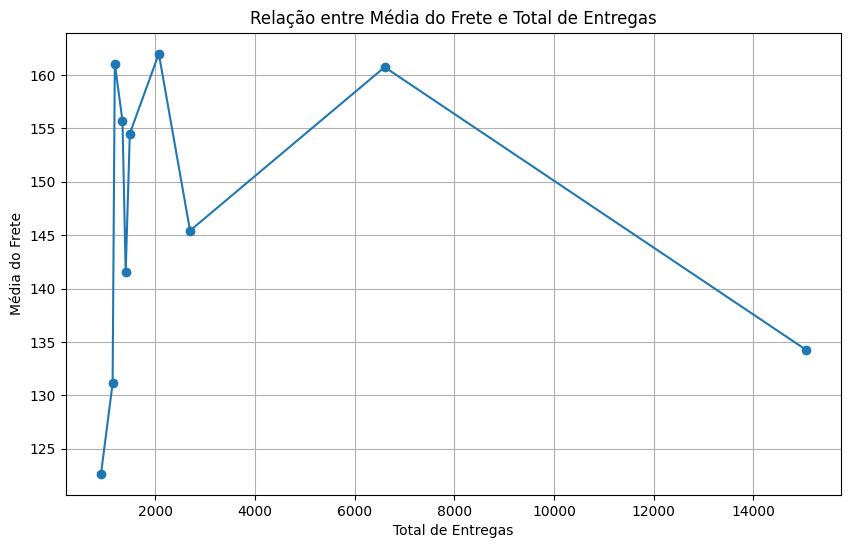

In [60]:


# Juntar os DataFrames usando a coluna 'cidade' como chave
df_merged = pd.merge(cidade_mais_entregas, media_frete, on='cidade', how='inner')


# Criar o gráfico
plt.figure(figsize=(10, 6))
plt.plot(df_merged['total_entregas'], df_merged['media_frete'], marker='o', linestyle='-')
plt.xlabel('Total de Entregas')
plt.ylabel('Média do Frete')
plt.title('Relação entre Média do Frete e Total de Entregas')
plt.grid(True)
plt.show()

#### Consulta de curiosidade, cidade de Teófilo Otoni

In [64]:
## observação: a string deve ser tratada em lower case ja que no dataset esta dessa forma, se consultássemos com Teófilo Otoni deve-se tratar os dados

query_clientes_teofilo_otoni = """
SELECT COUNT(DISTINCT customer_id) AS total_clientes
FROM customers
WHERE customer_city = 'teofilo otoni';
"""

clientes_teofilo_otoni = pd.read_sql_query(query_clientes_teofilo_otoni, conn)
print("Quantidade de clientes em Teófilo Otoni:")
print(clientes_teofilo_otoni)




Quantidade de clientes em Teófilo Otoni:
   total_clientes
0              75


In [65]:
query_produtos_teofilo_otoni = """
SELECT p.product_category_name AS categoria,
       COUNT(i.order_id) AS total_compras
FROM orders o
JOIN items i ON o.order_id = i.order_id
JOIN products p ON i.product_id = p.product_id
JOIN customers c ON o.customer_id = c.customer_id
WHERE c.customer_city = 'teofilo otoni'
      AND o.order_status = 'delivered'
GROUP BY p.product_category_name
ORDER BY total_compras DESC
LIMIT 10;
"""

produtos_teofilo_otoni = pd.read_sql_query(query_produtos_teofilo_otoni, conn)
print("Produtos mais comprados em Teófilo Otoni:")
print(produtos_teofilo_otoni)


Produtos mais comprados em Teófilo Otoni:
                           categoria  total_compras
0              utilidades_domesticas             10
1                    cama_mesa_banho              9
2                         brinquedos              8
3                         automotivo              8
4                      esporte_lazer              7
5             informatica_acessorios              6
6  construcao_ferramentas_construcao              6
7                       beleza_saude              6
8                          telefonia              5
9                   moveis_decoracao              5


In [66]:
query_vendedores_teofilo_otoni = """
SELECT COUNT(DISTINCT s.seller_id) AS total_vendedores
FROM sellers s
JOIN items i ON s.seller_id = i.seller_id
JOIN orders o ON i.order_id = o.order_id
JOIN customers c ON o.customer_id = c.customer_id
WHERE c.customer_city = 'teofilo otoni'
      AND o.order_status = 'delivered';
"""

vendedores_teofilo_otoni = pd.read_sql_query(query_vendedores_teofilo_otoni, conn)
print("Quantidade de vendedores em Teófilo Otoni:")
print(vendedores_teofilo_otoni)


Quantidade de vendedores em Teófilo Otoni:
   total_vendedores
0                73
